In [23]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.pyplot  as plt
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error as mse
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import pickle
from sklearn.externals import joblib 

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def week_login(data):
    for i in range(0,4):    
        data['week'+str(i+1)+'_log'] = (data[str(i+1)] + data[str(i+2)] + data[str(i+3)] + data[str(i+4)] + data[str(i+5)] + data[str(i+6)] + data[str(i+7)]) / 7
        
    data = data.drop(['1','2','3','4','5','6','7','8','9','10','11','12','13','14',
                                               '15','16','17','18','19','20','21','22','23','24','25','26','27','28'], axis=1)

    return data

In [0]:
data = pd.read_csv('/content/drive/My Drive/merge_all_flatten.csv')    
train_label = pd.read_csv('/content/drive/My Drive/train_label_add.csv')
train_label = train_label.sort_values('acc_id')

del data['minus']
del data['plus']

data = week_login(data)
data_lbl = pd.merge(data, train_label, on='acc_id')

In [5]:
from sklearn.model_selection import train_test_split
data_lbl['w_amount_spent'] = data_lbl['amount_spent_y']*data_lbl['amount_spent_y']

X_train_ta, X_test_ta, y_train_ta, y_test_ta = train_test_split(data[data.columns[1:]], data_lbl['w_amount_spent'], test_size=0.3, random_state=42)
#X_train_ta, X_valid_ta, y_train_ta, y_valid_ta = train_test_split(X_train_ta, y_train_ta, test_size=0.25, random_state=42)

X_train_ta.shape, X_test_ta.shape,y_train_ta.shape, y_test_ta.shape

((28000, 376), (12000, 376), (28000,), (12000,))

In [0]:
ind = data_lbl.reset_index()

In [0]:
%%time
from sklearn.model_selection import KFold

threshholds = ['0.71*mean', "0.72*mean","0.73*mean","0.74*mean", "0.75*mean","0.76*mean", "0.77*mean" , "0.78*mean", "0.79*mean","0.81*mean", "0.82*mean", "0.83*mean","0.84*mean",'0.85*mean','0.86*mean','0.87*mean']

for thresh in threshholds:
  model_ta = xgb.XGBRegressor(learning_rate= 0.02, 
      gamma = 0.3, 
      min_child_weight = 3,
      nthread = 15,
      max_depth= 30,
      subsample= 0.9,
      eval_metric= 'rmse',
      colsample_bytree= 0.8, 
      n_estimators=500,
      max_leaves=300)

  select_ta = SelectFromModel(model_ta, threshold=thresh)
  select_ta.fit(X_train_ta,y_train_ta)

  X_train_s1_ta = select_ta.transform(X_train_ta)
  X_test_s1_ta = select_ta.transform(X_test_ta)
  
  print("X_train_s1.shape : {}".format(X_train_s1_ta.shape))
  

  X = X_train_s1_ta
  y = y_train_ta
  y= y.reset_index(drop=True)


  kf = KFold(n_splits=5, random_state=42, shuffle=True)
  kf.get_n_splits(X)

  print(kf)  

  KFold(n_splits=5, random_state=42, shuffle=True)
  for train_index, test_index in kf.split(X):
      #print("TRAIN:", train_index, "TEST:", test_index)
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]

  dtrain = xgb.DMatrix(X_train, label=y_train)
  dvalid = xgb.DMatrix(X_test, label=y_test)
  dtest = xgb.DMatrix(X_test_s1_ta)
  watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

  # Try different parameters! My favorite is random search :)
  xgb_pars = {'learning_rate': 0.02, 
      'gamma' : 0.3, 
      'min_child_weight' : 3,
      'nthread' : 15,
      'max_depth' : 30,
      'subsample' : 0.9,
      'eval_metric' : 'rmse',
      'colsample_bytree' : 0.8, 
      'num_boost_round' : 500,
      'n_estimators': 500,
      'max_leaves': 300,
      'objective': 'reg:squarederror'}
  model = xgb.train(xgb_pars, dtrain, 500,  watchlist,maximize=False, 
                        early_stopping_rounds = 30, verbose_eval=50)

  y_pred = model.predict(dtest)
  real = y_test_ta.reset_index()
  real['amount_spent_pred'] = y_pred
  linreg_RMSEk_w = np.sqrt(mse(real['amount_spent_pred'], real['w_amount_spent']))
  spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
  linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))

  print("가중치 적용 라벨 rmse: ",linreg_RMSEk_w)
  print("Thresh=%s, n=%d,  rmse: %3f" % (thresh, X_train_s1_ta.shape[1], linreg_RMSEk))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[07:17:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
X_train_s1.shape : (28000, 150)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:3.33246	valid-rmse:3.00258
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[50]	train-rmse:2.38349	valid-rmse:2.97579
Stopping. Best iteration:
[29]	train-rmse:2.6951	valid-rmse:2.95644

가중치 적용 라벨 rmse:  2.8961737495176667
Thresh=0.71*mean, n=150,  rmse: 0.914113


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[07:37:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
X_train_s1.shape : (28000, 150)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:3.33246	valid-rmse:3.00258
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[50]	train-rmse:2.38349	valid-rmse:2.97579
Stopping. Best iteration:
[29]	train-rmse:2.6951	valid-rmse:2.95644

가중치 적용 라벨 rmse:  2.8961737495176667
Thresh=0.72*mean, n=150,  rmse: 0.914113


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[07:58:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
X_train_s1.shape : (28000, 147)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:3.33712	valid-rmse:2.99983
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[50]	train-rmse:2.39639	valid-rmse:2.966
Stopping. Best iteration:
[63]	train-rmse:2.22723	valid-rmse:2.96218

가중치 적용 라벨 rmse:  2.926786559788096
Thresh=0.73*mean, n=147,  rmse: 1.062047
[08:18:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (28000, 145)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:3.34025	valid-rmse:3.00472
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[50]	train-rmse:2.39779	valid-rmse:2.96863
Stopping. Best iteration:
[50]	train-rmse:2.39779	valid-rmse:2.96863

가중치 적용 라벨 rmse:  2.924587917860117
Thresh=0.74*mean, n=145,  rmse: 1.040819
[08:39:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (28000, 143)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:3.33901	valid-rmse:3.00321
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[50]	train-rmse:2.38997	valid-rmse:2.98814
Stopping. Best iteration:
[26]	train-rmse:2.75742	valid-rmse:2.958

가중치 적용 라벨 rmse:  2.891739359287189
Thresh=0.75*mean, n=143,  rmse: 0.927419
[08:59:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (28000, 142)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:3.33352	valid-rmse:2.99988
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[50]	train-rmse:2.39902	valid-rmse:2.96143
Stopping. Best iteration:
[22]	train-rmse:2.85272	valid-rmse:2.95536

가중치 적용 라벨 rmse:  2.8949519899341785
Thresh=0.76*mean, n=142,  rmse: 0.951561


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:19:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
X_train_s1.shape : (28000, 139)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:3.3339	valid-rmse:2.99986
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
Stopping. Best iteration:
[19]	train-rmse:2.89858	valid-rmse:2.96941

가중치 적용 라벨 rmse:  2.8707128211532136
Thresh=0.77*mean, n=139,  rmse: 0.896783
[09:39:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (28000, 139)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:3.3339	valid-rmse:2.99986
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
Stopping. Best iteration:
[19]	train-rmse:2.89858	valid-rmse:2.96941

가중치 적용 라벨 rmse:  2.8707128211532136
Thresh=0.78*mean, n=139,  rmse: 0.896783
[09:59:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [28]:
# min max 실험
X = X_train_ta.values
y = y_train_ta
y= y.reset_index(drop=True)


kf = KFold(n_splits=5, random_state=42, shuffle=True)
kf.get_n_splits(X)

print(kf)  

KFold(n_splits=5, random_state=42, shuffle=True)
for train_index, test_index in kf.split(X):
      #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)
dtest = xgb.DMatrix(X_test_ta.values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

  # Try different parameters! My favorite is random search :)
xgb_pars = {'learning_rate': 0.01, 
      'gamma' : 0.1, 
      'min_child_weight' : 10,
      'nthread' : 15,
      'max_depth' : 50,
      'subsample' : 0.5,
      'eval_metric' : 'rmse',
      'colsample_bytree' : 0.8, 
      'num_boost_round' : 500,
      'n_estimators': 500,
      'max_leaves': 300,
      'objective': 'reg:squarederror'}
model = xgb.train(xgb_pars, dtrain, 500,  watchlist,maximize=False, 
                        early_stopping_rounds = 30, verbose_eval=50)

y_pred = model.predict(dtest)
real = y_test_ta.reset_index()
real['amount_spent_pred'] = y_pred
linreg_RMSEk_w = np.sqrt(mse(real['amount_spent_pred'], real['w_amount_spent']))
spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))

print("가중치 적용 라벨 rmse: ",linreg_RMSEk_w)
#print("Thresh=%s, n=%d,  rmse: %3f" % (thresh, X_train_s1_ta.shape[1], linreg_RMSEk))

KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:17.9321	valid-rmse:15.1371
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[50]	train-rmse:16.8122	valid-rmse:15.1014
Stopping. Best iteration:
[21]	train-rmse:17.4249	valid-rmse:15.0771

가중치 적용 라벨 rmse:  13.376480552817345


1.7387880033899028


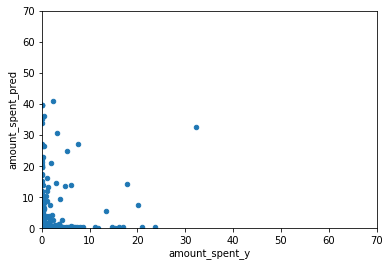

In [29]:
# min_child_weight 올리고 , 감마 내리고, depth 30 
ind = data_lbl.reset_index()
spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))

print(linreg_RMSEk)
spent_compare.plot(kind='scatter', x='amount_spent_y', y = 'amount_spent_pred',alpha= 1)
plt.axis([0, 70, 0, 70]); plt.show()

1.7387880033899028


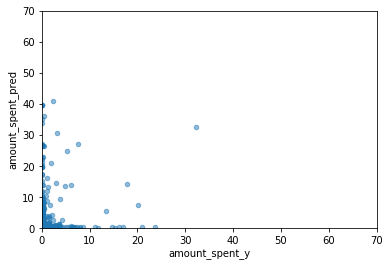

In [30]:
# min_child_weight 올리고 , 감마 내리고, depth 30 
ind = data_lbl.reset_index()
spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))

print(linreg_RMSEk)
spent_compare.plot(kind='scatter', x='amount_spent_y', y = 'amount_spent_pred',alpha= 0.5)
plt.axis([0, 70, 0, 70]); plt.show()

1.9203506633796672


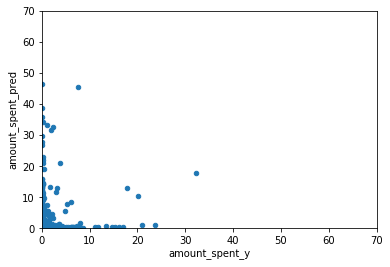

In [25]:
ind = data_lbl.reset_index()
spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))

print(linreg_RMSEk)
spent_compare.plot(kind='scatter', x='amount_spent_y', y = 'amount_spent_pred',alpha= 1)
plt.axis([0, 70, 0, 70]); plt.show()

# 과금 유저를 대상으로 log 가중치 주기

In [0]:
data_lbl['spent_1'] = np.where(data_lbl['amount_spent_y']>0, 1, 0) # 일평균 결제량이 1 이상이면 1, 아니면 0

data_055 = data_lbl[data_lbl['amount_spent_y']>0].drop(['Unnamed: 0', 'survival_time', 'amount_spent_y', 'secession',
       'total_spent', 'spent_1','w_amount_spent'], axis=1)

In [0]:
#가중치
data_lbl['w_amount_spent'] = data_lbl['amount_spent_y']*np.log(data_lbl['amount_spent_y']+1)*1.5

In [14]:
data_055.columns

Index(['acc_id', 'temp_cnt_x', 'private_shop', 'level_x', 'party_exp',
       'pledge_cnt', 'random_attacker_cnt_x', 'random_defender_cnt_x',
       'same_pledge_cnt_x', 'etc_cnt_x',
       ...
       'combat_play_time_4', 'pledge_rank_4', 'amount_spent_1',
       'amount_spent_2', 'amount_spent_3', 'amount_spent_4', 'week1_log',
       'week2_log', 'week3_log', 'week4_log'],
      dtype='object', length=377)

In [19]:
from sklearn.model_selection import train_test_split

X_train_ta, X_test_ta, y_train_ta, y_test_ta = train_test_split(data_055[data_055.columns[1:]], data_lbl[data_lbl['amount_spent_y']>0]['w_amount_spent'], test_size=0.2, random_state=42)
#X_train_ta, X_valid_ta, y_train_ta, y_valid_ta = train_test_split(X_train_ta, y_train_ta, test_size=0.25, random_state=42)

X_train_ta.shape, X_test_ta.shape,y_train_ta.shape, y_test_ta.shape

((18849, 376), (4713, 376), (18849,), (4713,))

In [82]:
X = X_train_ta.values
y = y_train_ta
y= y.reset_index(drop=True)


kf = KFold(n_splits=5, random_state=42, shuffle=True)
kf.get_n_splits(X)

print(kf)  

KFold(n_splits=5, random_state=42, shuffle=True)
for train_index, test_index in kf.split(X):
      #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)
dtest = xgb.DMatrix(X_test_ta.values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

  # Try different parameters! My favorite is random search :)
xgb_pars = {'learning_rate': 0.01, 
      'gamma' : 0.1, 
      'min_child_weight' : 10,
      'nthread' : 15,
      'max_depth' : 50,
      'subsample' : 0.5,
      'eval_metric' : 'rmse',
      'colsample_bytree' : 0.8, 
      'num_boost_round' : 500,
      'n_estimators': 500,
      'max_leaves': 300,
      'objective': 'reg:squarederror'}
model = xgb.train(xgb_pars, dtrain, 500,  watchlist,maximize=False, 
                        early_stopping_rounds = 30, verbose_eval=50)

y_pred = model.predict(dtest)
real = y_test_ta.reset_index()
real['amount_spent_pred'] = y_pred
linreg_RMSEk_w = np.sqrt(mse(real['amount_spent_pred'], real['w_amount_spent']))
spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))

print("가중치 적용 라벨 rmse: ",linreg_RMSEk_w)
#print("Thresh=%s, n=%d,  rmse: %3f" % (thresh, X_train_s1_ta.shape[1], linreg_RMSEk))

KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:3.9331	valid-rmse:4.99488
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[50]	train-rmse:3.73998	valid-rmse:4.85093
[100]	train-rmse:3.60942	valid-rmse:4.79056
[150]	train-rmse:3.49849	valid-rmse:4.75017
[200]	train-rmse:3.39473	valid-rmse:4.71719
Stopping. Best iteration:
[198]	train-rmse:3.39777	valid-rmse:4.71589

가중치 적용 라벨 rmse:  3.614003131646849


1.049934573298857


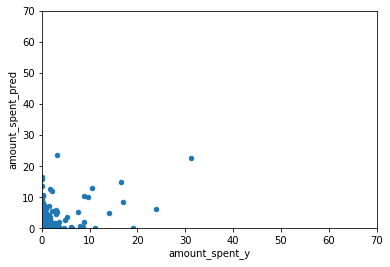

In [83]:
# 0 초과인 유저 log 가중치 * 1.5 (전체 특성 사용)
ind = data_lbl.reset_index()
spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))

print(linreg_RMSEk)
spent_compare.plot(kind='scatter', x='amount_spent_y', y = 'amount_spent_pred',alpha= 1)
plt.axis([0, 70, 0, 70]); plt.show()

0.8706579065220652


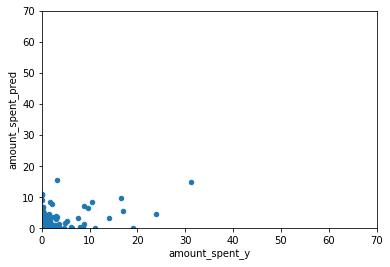

In [79]:
# 0 초과인 유저 log 가중치
ind = data_lbl.reset_index()
spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))

print(linreg_RMSEk)
spent_compare.plot(kind='scatter', x='amount_spent_y', y = 'amount_spent_pred',alpha= 1)
plt.axis([0, 70, 0, 70]); plt.show()

4.700643244715566


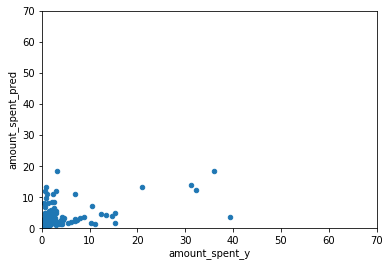

In [74]:
# 0.55 이상인 유저 log 가중치
ind = data_lbl.reset_index()
spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))

print(linreg_RMSEk)
spent_compare.plot(kind='scatter', x='amount_spent_y', y = 'amount_spent_pred',alpha= 1)
plt.axis([0, 70, 0, 70]); plt.show()

# 변수 선택 후 0 초과 유저만 학습(12000점 파라미터)

In [0]:
# 일평균
%%time
model_ta = xgb.XGBRegressor(learning_rate= 0.01, 
      gamma = 0.1, 
      min_child_weight = 10,
      max_depth= 50,
      subsample= 0.5,
      eval_metric= 'rmse',
      colsample_bytree= 0.8, 
      n_estimators=500,
      max_leaves=300
                        )

select_ta = SelectFromModel(model_ta, threshold="1.2*mean")
select_ta.fit(X_train_ta,y_train_ta)

feature_idx_all = select_ta.get_support()
feature_name_all = data[data.columns[1:]].columns[feature_idx_all]


X_train_s1_ta = select_ta.transform(X_train_ta)
X_test_s1_ta = select_ta.transform(X_test_ta)
  
print("X_train_s1.shape : {}".format(X_train_s1_ta.shape))
  

X = X_train_s1_ta
y = y_train_ta
y= y.reset_index(drop=True)


kf = KFold(n_splits=10)
kf.get_n_splits(X)

print(kf)  

KFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)
dtest = xgb.DMatrix(X_test_s1_ta)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Try different parameters! My favorite is random search :)
xgb_pars = {'learning_rate': 0.01, 
      'gamma' : 0.1, 
      'min_child_weight' : 10,
      'nthread' : 15,
      'max_depth' : 50,
      'subsample' : 0.5,
      'eval_metric' : 'rmse',
      'colsample_bytree' : 0.8, 
      'num_boost_round' : 500,
      'n_estimators': 500,
      'max_leaves': 300,
      'objective': 'reg:squarederror'
           }
model_ta = xgb.train(xgb_pars, dtrain, 1500, watchlist  ,early_stopping_rounds=50,
                  maximize=False, verbose_eval=20)
#plt.figure(figsize=(15,10))
y_pred = model.predict(dtest)
real = y_test_ta.reset_index()
real['amount_spent_pred'] = y_pred
linreg_RMSEk_w = np.sqrt(mse(real['amount_spent_pred'], real['w_amount_spent']))
spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))

print("가중치 적용 라벨 rmse: ",linreg_RMSEk_w)
plt.plot(real['w_amount_spent'],real['amount_spent_pred'],'bo')
plt.axis([0, 70, 0, 70]); plt.show()

가중치 적용 라벨 rmse:  3.6515548524979398


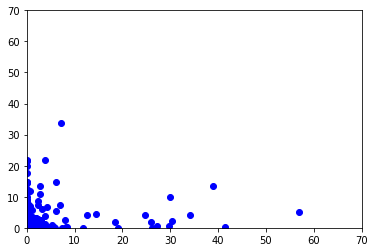

In [92]:
y_pred = model_ta.predict(dtest)
real = y_test_ta.reset_index()
real['amount_spent_pred'] = y_pred
real['amount_spent_pred'] = y_pred
linreg_RMSEk_w = np.sqrt(mse(real['amount_spent_pred'], real['w_amount_spent']))
spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))

print("가중치 적용 라벨 rmse: ",linreg_RMSEk_w)
plt.plot(real['w_amount_spent'],real['amount_spent_pred'],'bo')
plt.axis([0, 70, 0, 70]); plt.show()

1.3545754060635895


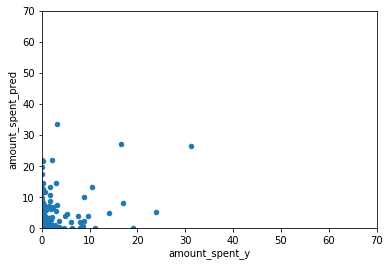

In [93]:
# 0초과 유저 1.2평균 임계로 특성 선택, log 1.5 가중치
ind = data_lbl.reset_index()
spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))

print(linreg_RMSEk)
spent_compare.plot(kind='scatter', x='amount_spent_y', y = 'amount_spent_pred',alpha= 1)
plt.axis([0, 70, 0, 70]); plt.show()

## 1.2mean으로 잘 나왔으니 최적화를 할 차례

In [0]:
import pickle
from sklearn.externals import joblib 

In [127]:
%%time
# 일평균 결제량 가중치 로그*1.5 회귀 분석
from sklearn.model_selection import KFold

threshholds = ["0.8*mean", "1.1*mean","1.15*mean", "1.25*mean" , "1.35*mean","1.45*mean"]

# save list
features_index = []
features_name = []
predict_value = []
i=0
for thresh in threshholds:
  model_ta = xgb.XGBRegressor(learning_rate= 0.01, 
      gamma = 0.1, 
      min_child_weight = 10,
      nthread = 15,
      max_depth= 50,
      subsample= 0.5,
      eval_metric= 'rmse',
      colsample_bytree= 0.8, 
      n_estimators=500,
      max_leaves=300)

  select_ta = SelectFromModel(model_ta, threshold=thresh)
  select_ta.fit(X_train_ta,y_train_ta)

  X_train_s1_ta = select_ta.transform(X_train_ta)
  X_test_s1_ta = select_ta.transform(X_test_ta)
  
  print("X_train_s1.shape : {}".format(X_train_s1_ta.shape))
  
  # feature name save
  feature_idx_all = select_ta.get_support()
  feature_name_all = data_055[data_055.columns[1:]].columns[feature_idx_all]
  
  # k_fold
  X = X_train_s1_ta
  y = y_train_ta
  y= y.reset_index(drop=True)


  kf = KFold(n_splits=5, random_state=42, shuffle=True)
  kf.get_n_splits(X)

  print(kf)  

  KFold(n_splits=5, random_state=42, shuffle=True)
  for train_index, test_index in kf.split(X):
      #print("TRAIN:", train_index, "TEST:", test_index)
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]

  dtrain = xgb.DMatrix(X_train, label=y_train)
  dvalid = xgb.DMatrix(X_test, label=y_test)
  dtest = xgb.DMatrix(X_test_s1_ta)
  watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

  # parameters
  xgb_pars = {'learning_rate': 0.01, 
      'gamma' : 0.1, 
      'min_child_weight' : 10,
      'nthread' : 15,
      'max_depth' : 50,
      'subsample' : 0.5,
      'eval_metric' : 'rmse',
      'colsample_bytree' : 0.8, 
      'num_boost_round' : 500,
      'n_estimators': 500,
      'max_leaves': 300,
      'objective': 'reg:squarederror'}
  model = xgb.train(xgb_pars, dtrain, 1500,  watchlist,maximize=False, 
                        early_stopping_rounds = 50, verbose_eval=50)
  file_name = '/content/drive/My Drive/amount_select'+str(i)+'.pkl' 
  joblib.dump(model, file_name)
  i = i +1
  #
  y_pred = model.predict(dtest)
  
  # 값 저장
  features_index.append(feature_idx_all)
  features_name.append(feature_name_all)
  predict_value.append(y_pred)
  
  #
  
  real = y_test_ta.reset_index()
  real['amount_spent_pred'] = y_pred
  linreg_RMSEk_w = np.sqrt(mse(real['amount_spent_pred'], real['w_amount_spent']))
  spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
  linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))

  print("가중치 적용 라벨 rmse: ",linreg_RMSEk_w)
  print("Thresh=%s, n=%d,  rmse: %3f" % (thresh, X_train_s1_ta.shape[1], linreg_RMSEk))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:05:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
X_train_s1.shape : (18849, 124)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:3.9323	valid-rmse:4.99631
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:3.74089	valid-rmse:4.83588
[100]	train-rmse:3.60931	valid-rmse:4.77009
[150]	train-rmse:3.50457	valid-rmse:4.72789
[200]	train-rmse:3.39928	valid-rmse:4.70467
[250]	train-rmse:3.32169	valid-rmse:4.69837
[300]	train-rmse:3.24272	valid-rmse:4.68955
[350]	train-rmse:3.17002	valid-rmse:4.68627
Stopping. Best iteration:
[311]	train-rmse:3.22458	valid-rmse:4.68115

가중치 적용 라벨 rmse:  3.5401383027369175
Thresh=0.8*mean, n=124,  rmse: 1.114757
[18:24:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (18849, 93)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:3.9329	valid-rmse:4.99503
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:3.74196	valid-rmse:4.83637
[100]	train-rmse:3.60804	valid-rmse:4.76174
[150]	train-rmse:3.50063	valid-rmse:4.72691
[200]	train-rmse:3.40018	valid-rmse:4.69561
[250]	train-rmse:3.32275	valid-rmse:4.67974
[300]	train-rmse:3.24404	valid-rmse:4.66835
[350]	train-rmse:3.17183	valid-rmse:4.67577
Stopping. Best iteration:
[311]	train-rmse:3.22555	valid-rmse:4.66178

가중치 적용 라벨 rmse:  3.526265559868109
Thresh=1.1*mean, n=93,  rmse: 1.122972
[18:42:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (18849, 89)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:3.9326	valid-rmse:4.9952
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:3.74628	valid-rmse:4.84175
[100]	train-rmse:3.61809	valid-rmse:4.76437
[150]	train-rmse:3.51276	valid-rmse:4.74036
[200]	train-rmse:3.41446	valid-rmse:4.70832
[250]	train-rmse:3.33387	valid-rmse:4.69999
[300]	train-rmse:3.25759	valid-rmse:4.69707
[350]	train-rmse:3.18625	valid-rmse:4.69535
Stopping. Best iteration:
[310]	train-rmse:3.24031	valid-rmse:4.6863

가중치 적용 라벨 rmse:  3.549597938149096
Thresh=1.15*mean, n=89,  rmse: 1.103274
[18:59:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (18849, 84)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:3.93277	valid-rmse:4.99461
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:3.74696	valid-rmse:4.84872
[100]	train-rmse:3.61688	valid-rmse:4.77477
[150]	train-rmse:3.51199	valid-rmse:4.73106
[200]	train-rmse:3.41479	valid-rmse:4.69977
[250]	train-rmse:3.33746	valid-rmse:4.68016
[300]	train-rmse:3.25874	valid-rmse:4.68094
[350]	train-rmse:3.18861	valid-rmse:4.68213
Stopping. Best iteration:
[311]	train-rmse:3.2402	valid-rmse:4.67412

가중치 적용 라벨 rmse:  3.5371486739477147
Thresh=1.25*mean, n=84,  rmse: 1.104954
[19:18:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (18849, 73)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:3.933	valid-rmse:4.99466
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:3.74411	valid-rmse:4.83139
[100]	train-rmse:3.61773	valid-rmse:4.76583
[150]	train-rmse:3.51359	valid-rmse:4.72473
[200]	train-rmse:3.41254	valid-rmse:4.69347
[250]	train-rmse:3.33722	valid-rmse:4.69548
[300]	train-rmse:3.25644	valid-rmse:4.67785
[350]	train-rmse:3.18762	valid-rmse:4.66077
[400]	train-rmse:3.12149	valid-rmse:4.65738
[450]	train-rmse:3.06255	valid-rmse:4.66047
Stopping. Best iteration:
[419]	train-rmse:3.09661	valid-rmse:4.65265

가중치 적용 라벨 rmse:  3.538003940135246
Thresh=1.35*mean, n=73,  rmse: 1.228880
[19:36:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (18849, 65)
KFold(n_splits=5, random_state=42, shuffle=True)
[0]	train-rmse:3.93298	valid-rmse:4.99514
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[50]	train-rmse:3.75236	valid-rmse:4.8197
[100]	train-rmse:3.63139	valid-rmse:4.74593
[150]	train-rmse:3.52657	valid-rmse:4.71337
[200]	train-rmse:3.42633	valid-rmse:4.68
[250]	train-rmse:3.3507	valid-rmse:4.66667
[300]	train-rmse:3.27241	valid-rmse:4.64044
[350]	train-rmse:3.20111	valid-rmse:4.62883
[400]	train-rmse:3.13226	valid-rmse:4.62321
Stopping. Best iteration:
[388]	train-rmse:3.14919	valid-rmse:4.61884

가중치 적용 라벨 rmse:  3.5500152832777285
Thresh=1.45*mean, n=65,  rmse: 1.213719
CPU times: user 3h 27min 29s, sys: 3min 56s, total: 3h 31min 25s
Wall time: 1h 49min 23s


1.3545754060635895


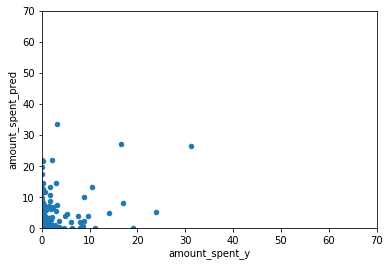

In [120]:
# 0초과 유저 전체 특성, log 1.6 가중치
y_pred = model_ta.predict(dtest)
real = y_test_ta.reset_index()
real['amount_spent_pred'] = y_pred
ind = data_lbl.reset_index()
spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))

print(linreg_RMSEk)
spent_compare.plot(kind='scatter', x='amount_spent_y', y = 'amount_spent_pred',alpha= 1)
plt.axis([0, 70, 0, 70]); plt.show()

1.049934573298857


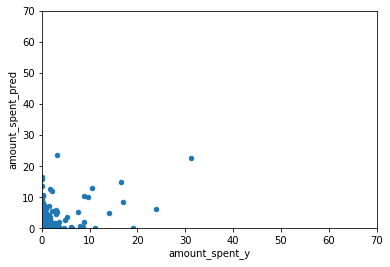

In [117]:
# 0초과 유저 전체 특성, log 1.6 가중치
ind = data_lbl.reset_index()
spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))

print(linreg_RMSEk)
spent_compare.plot(kind='scatter', x='amount_spent_y', y = 'amount_spent_pred',alpha= 1)
plt.axis([0, 70, 0, 70]); plt.show()

In [24]:
### 점심 먹고 확인
# 1.1 사이로 mean
# 1.1mean 기준으로 세부 조정
%%time
# 일평균 결제량 가중치 로그*1.6 회귀 분석
from sklearn.model_selection import KFold

threshholds = ["1.11*mean","1.12*mean", "1.13*mean","1.14*mean", "1.15*mean" , "1.16*mean", "1.17*mean","1.18*mean", "1.19*mean"]

# save list
features_index = []
features_name = []
predict_value = []
i = 0
for thresh in threshholds:
  model_ta = xgb.XGBRegressor(learning_rate= 0.01, 
      gamma = 0.1, 
      min_child_weight = 10,
      nthread = 15,
      max_depth= 50,
      subsample= 0.5,
      eval_metric= 'rmse',
      colsample_bytree= 0.8, 
      n_estimators=500,
      max_leaves=300)

  select_ta = SelectFromModel(model_ta, threshold=thresh)
  select_ta.fit(X_train_ta,y_train_ta)

  X_train_s1_ta = select_ta.transform(X_train_ta)
  X_test_s1_ta = select_ta.transform(X_test_ta)
  
  print("X_train_s1.shape : {}".format(X_train_s1_ta.shape))
  
  # feature name save
  feature_idx_all = select_ta.get_support()
  feature_name_all = data_055[data_055.columns[1:]].columns[feature_idx_all]
  
  # k_fold
  X = X_train_s1_ta
  y = y_train_ta
  y= y.reset_index(drop=True)


  kf = KFold(n_splits=5, random_state=42, shuffle=True)
  kf.get_n_splits(X)

  print(kf)  

  KFold(n_splits=5, random_state=42, shuffle=True)
  for train_index, test_index in kf.split(X):
      #print("TRAIN:", train_index, "TEST:", test_index)
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]

  dtrain = xgb.DMatrix(X_train, label=y_train)
  dvalid = xgb.DMatrix(X_test, label=y_test)
  dtest = xgb.DMatrix(X_test_s1_ta)
  watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

  # parameters
  xgb_pars = {'learning_rate': 0.01, 
      'gamma' : 0.1, 
      'min_child_weight' : 10,
      'nthread' : 15,
      'max_depth' : 50,
      'subsample' : 0.5,
      'eval_metric' : 'rmse',
      'colsample_bytree' : 0.8, 
      'num_boost_round' : 500,
      'n_estimators': 500,
      'max_leaves': 300,
      'objective': 'reg:squarederror'}
  model = xgb.train(xgb_pars, dtrain, 1500,  watchlist,maximize=False, 
                        early_stopping_rounds = 50, verbose_eval=50)
  #
  file_name = '/content/drive/My Drive/total_select_1_1'+str(i)+'_0906.pkl' 
  joblib.dump(model, file_name)
  
  file_name = '/content/drive/My Drive/total_model_1_1'+str(i)+'_0906.pkl' 
  joblib.dump(select_ta, file_name)
  i = i +1
  y_pred = model.predict(dtest)
  
  # 값 저장
  features_index.append(feature_idx_all)
  features_name.append(feature_name_all)
  predict_value.append(y_pred)
  
  #
  
  real = y_test_ta.reset_index()
  real['amount_spent_pred'] = y_pred
  linreg_RMSEk_w = np.sqrt(mse(real['amount_spent_pred'], real['w_amount_spent']))
  spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
  linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))

  print("가중치 적용 라벨 rmse: ",linreg_RMSEk_w)
  print("Thresh=%s, n=%d,  rmse: %3f" % (thresh, X_train_s1_ta.shape[1], linreg_RMSEk))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:40:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
X_train_s1.shape : (18849, 93)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:3.9329	valid-rmse:4.99503
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:3.74196	valid-rmse:4.83637
[100]	train-rmse:3.60804	valid-rmse:4.76174
[150]	train-rmse:3.50063	valid-rmse:4.72691
[200]	train-rmse:3.40018	valid-rmse:4.69561
[250]	train-rmse:3.32275	valid-rmse:4.67974
[300]	train-rmse:3.24404	valid-rmse:4.66835
[350]	train-rmse:3.17183	valid-rmse:4.67577
Stopping. Best iteration:
[311]	train-rmse:3.22555	valid-rmse:4.66178

가중치 적용 라벨 rmse:  3.526265559868109
Thresh=1.11*mean, n=93,  rmse: 1.122972
[04:59:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (18849, 92)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:3.93266	valid-rmse:4.99505
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:3.74653	valid-rmse:4.84295
[100]	train-rmse:3.6152	valid-rmse:4.76502
[150]	train-rmse:3.51058	valid-rmse:4.73356
[200]	train-rmse:3.40748	valid-rmse:4.70868
[250]	train-rmse:3.33049	valid-rmse:4.7016
[300]	train-rmse:3.25113	valid-rmse:4.69009
[350]	train-rmse:3.18056	valid-rmse:4.6731
Stopping. Best iteration:
[344]	train-rmse:3.18976	valid-rmse:4.67033

가중치 적용 라벨 rmse:  3.5303134892249433
Thresh=1.12*mean, n=92,  rmse: 1.174051


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[05:18:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
X_train_s1.shape : (18849, 92)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:3.93266	valid-rmse:4.99505
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:3.74653	valid-rmse:4.84295
[100]	train-rmse:3.6152	valid-rmse:4.76502
[150]	train-rmse:3.51058	valid-rmse:4.73356
[200]	train-rmse:3.40748	valid-rmse:4.70868
[250]	train-rmse:3.33049	valid-rmse:4.7016
[300]	train-rmse:3.25113	valid-rmse:4.69009
[350]	train-rmse:3.18056	valid-rmse:4.6731
Stopping. Best iteration:
[344]	train-rmse:3.18976	valid-rmse:4.67033

가중치 적용 라벨 rmse:  3.5303134892249433
Thresh=1.13*mean, n=92,  rmse: 1.174051
[05:37:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (18849, 90)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:3.93266	valid-rmse:4.99505
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:3.74683	valid-rmse:4.8423
[100]	train-rmse:3.61809	valid-rmse:4.76035
[150]	train-rmse:3.51438	valid-rmse:4.73348
[200]	train-rmse:3.41805	valid-rmse:4.69361
[250]	train-rmse:3.34116	valid-rmse:4.689
[300]	train-rmse:3.26637	valid-rmse:4.69041
[350]	train-rmse:3.1928	valid-rmse:4.6952
Stopping. Best iteration:
[310]	train-rmse:3.24867	valid-rmse:4.68344

가중치 적용 라벨 rmse:  3.5504926603953675
Thresh=1.14*mean, n=90,  rmse: 1.107779
[05:55:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (18849, 89)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:3.9326	valid-rmse:4.9952
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:3.74628	valid-rmse:4.84175
[100]	train-rmse:3.61809	valid-rmse:4.76437
[150]	train-rmse:3.51276	valid-rmse:4.74036
[200]	train-rmse:3.41446	valid-rmse:4.70832
[250]	train-rmse:3.33387	valid-rmse:4.69999
[300]	train-rmse:3.25759	valid-rmse:4.69707
[350]	train-rmse:3.18625	valid-rmse:4.69535
Stopping. Best iteration:
[310]	train-rmse:3.24031	valid-rmse:4.6863

가중치 적용 라벨 rmse:  3.549597938149096
Thresh=1.15*mean, n=89,  rmse: 1.103274
[06:14:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (18849, 89)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:3.9326	valid-rmse:4.9952
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:3.74628	valid-rmse:4.84175
[100]	train-rmse:3.61809	valid-rmse:4.76437
[150]	train-rmse:3.51276	valid-rmse:4.74036
[200]	train-rmse:3.41446	valid-rmse:4.70832
[250]	train-rmse:3.33387	valid-rmse:4.69999
[300]	train-rmse:3.25759	valid-rmse:4.69707
[350]	train-rmse:3.18625	valid-rmse:4.69535
Stopping. Best iteration:
[310]	train-rmse:3.24031	valid-rmse:4.6863

가중치 적용 라벨 rmse:  3.549597938149096
Thresh=1.16*mean, n=89,  rmse: 1.103274
[06:32:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (18849, 89)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:3.9326	valid-rmse:4.9952
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:3.74628	valid-rmse:4.84175
[100]	train-rmse:3.61809	valid-rmse:4.76437
[150]	train-rmse:3.51276	valid-rmse:4.74036
[200]	train-rmse:3.41446	valid-rmse:4.70832
[250]	train-rmse:3.33387	valid-rmse:4.69999
[300]	train-rmse:3.25759	valid-rmse:4.69707
[350]	train-rmse:3.18625	valid-rmse:4.69535
Stopping. Best iteration:
[310]	train-rmse:3.24031	valid-rmse:4.6863

가중치 적용 라벨 rmse:  3.549597938149096
Thresh=1.17*mean, n=89,  rmse: 1.103274


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[06:50:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
X_train_s1.shape : (18849, 88)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:3.93263	valid-rmse:4.99521
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:3.7483	valid-rmse:4.84559
[100]	train-rmse:3.61673	valid-rmse:4.76132
[150]	train-rmse:3.51403	valid-rmse:4.73039
[200]	train-rmse:3.41184	valid-rmse:4.70243
[250]	train-rmse:3.33235	valid-rmse:4.68933
Stopping. Best iteration:
[238]	train-rmse:3.34806	valid-rmse:4.68411

가중치 적용 라벨 rmse:  3.570071671223526
Thresh=1.18*mean, n=88,  rmse: 1.056774
[07:08:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (18849, 88)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:3.93263	valid-rmse:4.99521
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:3.7483	valid-rmse:4.84559
[100]	train-rmse:3.61673	valid-rmse:4.76132
[150]	train-rmse:3.51403	valid-rmse:4.73039
[200]	train-rmse:3.41184	valid-rmse:4.70243
[250]	train-rmse:3.33235	valid-rmse:4.68933
Stopping. Best iteration:
[238]	train-rmse:3.34806	valid-rmse:4.68411

가중치 적용 라벨 rmse:  3.570071671223526
Thresh=1.19*mean, n=88,  rmse: 1.056774
CPU times: user 5h 20min 11s, sys: 4min 30s, total: 5h 24min 42s
Wall time: 2h 45min 41s


# 개별 테스트

In [15]:
# 일평균
%%time
model_ta = xgb.XGBRegressor(learning_rate= 0.01, 
      gamma = 0.1, 
      min_child_weight = 10,
      max_depth= 50,
      subsample= 0.5,
      eval_metric= 'rmse',
      colsample_bytree= 0.8, 
      n_estimators=500,
      max_leaves=300
                        )

select_ta = SelectFromModel(model_ta, threshold="1.15*mean")
select_ta.fit(X_train_ta,y_train_ta)

feature_idx_all = select_ta.get_support()
feature_name_all = data[data.columns[1:]].columns[feature_idx_all]


X_train_s1_ta = select_ta.transform(X_train_ta)
X_test_s1_ta = select_ta.transform(X_test_ta)
  
print("X_train_s1.shape : {}".format(X_train_s1_ta.shape))
  

X = X_train_s1_ta
y = y_train_ta
y= y.reset_index(drop=True)


kf = KFold(n_splits=10)
kf.get_n_splits(X)

print(kf)  

KFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)
dtest = xgb.DMatrix(X_test_s1_ta)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Try different parameters! My favorite is random search :)
xgb_pars = {'learning_rate': 0.01, 
      'gamma' : 0.1, 
      'min_child_weight' : 10,
      'nthread' : 15,
      'max_depth' : 50,
      'subsample' : 0.5,
      'eval_metric' : 'rmse',
      'colsample_bytree' : 0.8, 
      'num_boost_round' : 500,
      'n_estimators': 500,
      'max_leaves': 300,
      'objective': 'reg:squarederror'
           }
model_ta = xgb.train(xgb_pars, dtrain, 1500, watchlist  ,early_stopping_rounds=50,
                  maximize=False, verbose_eval=20)
#plt.figure(figsize=(15,10))
y_pred = model_ta.predict(dtest)
real = y_test_ta.reset_index()
real['amount_spent_pred'] = y_pred
linreg_RMSEk_w = np.sqrt(mse(real['amount_spent_pred'], real['w_amount_spent']))
spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))

print("가중치 적용 라벨 rmse: ",linreg_RMSEk_w)
plt.plot(real['w_amount_spent'],real['amount_spent_pred'],'bo')
plt.axis([0, 70, 0, 70]); plt.show()

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:38:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
X_train_s1.shape : (28000, 67)
KFold(n_splits=10, random_state=None, shuffle=False)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:16.9336	valid-rmse:21.3565
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[20]	train-rmse:16.7145	valid-rmse:21.1843
[40]	train-rmse:16.472	valid-rmse:20.9582
[60]	train-rmse:16.2725	valid-rmse:20.872
[80]	train-rmse:16.1022	valid-rmse:20.7571
[100]	train-rmse:15.9545	valid-rmse:20.5939


KeyboardInterrupt: ignored

In [18]:
y_train_ta.max()

1553.355568948734

5.801017555897079


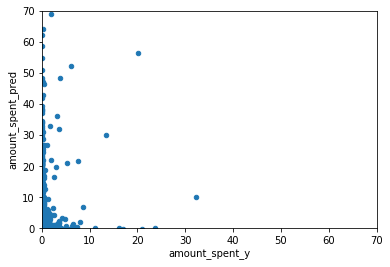

In [11]:
ind = data_lbl.reset_index()
spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))

print(linreg_RMSEk)
spent_compare.plot(kind='scatter', x='amount_spent_y', y = 'amount_spent_pred',alpha= 1)
plt.axis([0, 70, 0, 70]); plt.show()

# test!!

In [0]:
test1 = pd.read_csv('/content/drive/My Drive/merge_all_flatten_test1.csv')    
test2 = pd.read_csv('/content/drive/My Drive/merge_all_flatten_test2.csv') 

In [0]:

test1 = week_login(test1)
test2 = week_login(test2)


In [0]:
## 변수 선택 후 
sel_t1 = select_ta.transform(test1[test1.columns[1:]])
dtest_tt1 = xgb.DMatrix(sel_t1)
y_pred_t1 = model_ta.predict(dtest_tt1)

sel_t2 = select_ta.transform(test2[test2.columns[1:]])
dtest_tt2 = xgb.DMatrix(sel_t2)
y_pred_t2 = model_ta.predict(dtest_tt2)

In [98]:
# 결제량 입력
test1_am = test1[['acc_id']]
test1_am['amount_spent'] = y_pred_t1

test2_am = test2[['acc_id']]
test2_am['amount_spent'] = y_pred_t2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


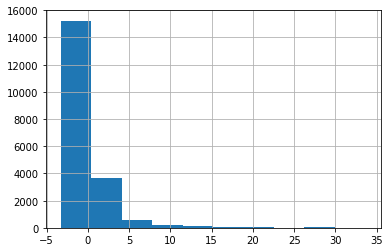

In [101]:
test1_am['amount_spent'].hist()

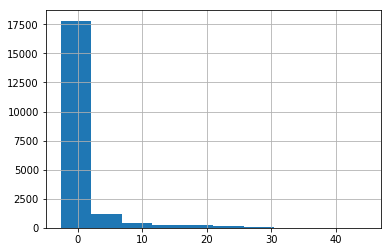

In [104]:
test2_am['amount_spent'].hist()

In [105]:
# -는 0으로
test1_am['amount_spent'] = np.where(test1_am['amount_spent']<0, 0,test1_am['amount_spent'])

test2_am['amount_spent'] = np.where(test2_am['amount_spent']<0, 0,test2_am['amount_spent'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
# 저장
test1_am.to_csv('/content/drive/My Drive/test1_am.csv', index=False)

test2_am.to_csv('/content/drive/My Drive/test2_am.csv', index=False)

In [113]:
import pickle
from sklearn.externals import joblib 
# 객체를 pickled binary file 형태로 저장한다 
file_name = '/content/drive/My Drive/xgb_w1_5_12000score_1_2_mean.pkl' 

joblib.dump(model_ta, file_name)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['/content/drive/My Drive/xgb_w1_5_12000score_1_2_mean.pkl']

In [114]:
import pickle
from sklearn.externals import joblib 
# 객체를 pickled binary file 형태로 저장한다 
file_name = '/content/drive/My Drive/select_w1_5_12000score_1_2_mean.pkl' 

joblib.dump(select_ta, file_name)

['/content/drive/My Drive/select_w1_5_12000score_1_2_mean.pkl']

In [111]:
feature_name_all.to_csv('/content/drive/My Drive/12000score_features.csv', index=False)

AttributeError: ignored

In [112]:
# 선택된 features
feature_name_all

Index(['level_x', 'playtime', 'quest_exp', 'playtime_count', 'solo_exp_count',
       'quest_exp_count', 'game_money_change_count', 'std_same',
       'acc_std_same', 'level_max', 'day_count', 'char_max', 'day_sum', 'C_1',
       'C_5', 'C_7', 'level_y', 'day_x', 'amount_spent', 'pay_count',
       'pay_mean', 'pay_mean_28', 'non_login_pay', 'pluss', 'minus_am',
       'plus_am', 'day_s', 'item_2_s', 'item_4_s', 'item_6_s', 'type_shop_s',
       'day_t', 'item_amount_t', 'item_2_t', 'item_3_t', 'type_shop_t',
       'num_trade_shop', 'sell_amount', 'margin', 'day_s_m', 'item_amount_s_m',
       'item_2_s_m', 'item_4_s_m', 'item_6_s_m', 'item_price_t_m',
       'day_s_x_nd', 'item_2_s_x_nd', 'day_s_y_nd', 'item_2_s_y_nd',
       'item_6_s_y_nd', 'type_ex_s_y_nd', 'type_shop_s_y_nd', 'trade_ratio',
       'tday_count_s', 'tday_mean_t', 'hour_mean', 'hour_s_800', 'hour_t_100',
       'hour_t_300', 'source_merchant_ratio', 'day_y', 'play_char_cnt',
       'pledge_rank', 'pledge_member_num'